In [18]:
import pandas as pd
import numpy as np

seeds = [f's{i}' for i in range(1, 11)]
experiments = ['baseline', 'fixed_1', 'fixed_2', 'dynamic_1']
tests_score = {}
run_stats = {}

for experiment in experiments:
    tests_data = f'../../datalake/data_{experiment}/data/xdpole/runstats'
    tests_score[experiment] = []
    run_stats[experiment] = []
    for seed in seeds:
        test = pd.read_csv(f'{tests_data}/{seed}_test.csv')
        tests_score[experiment].append(test.score[0])

        stats = pd.read_csv(f'{tests_data}/{seed}_run.csv')
        run_stats[experiment].append(stats.avgfit)

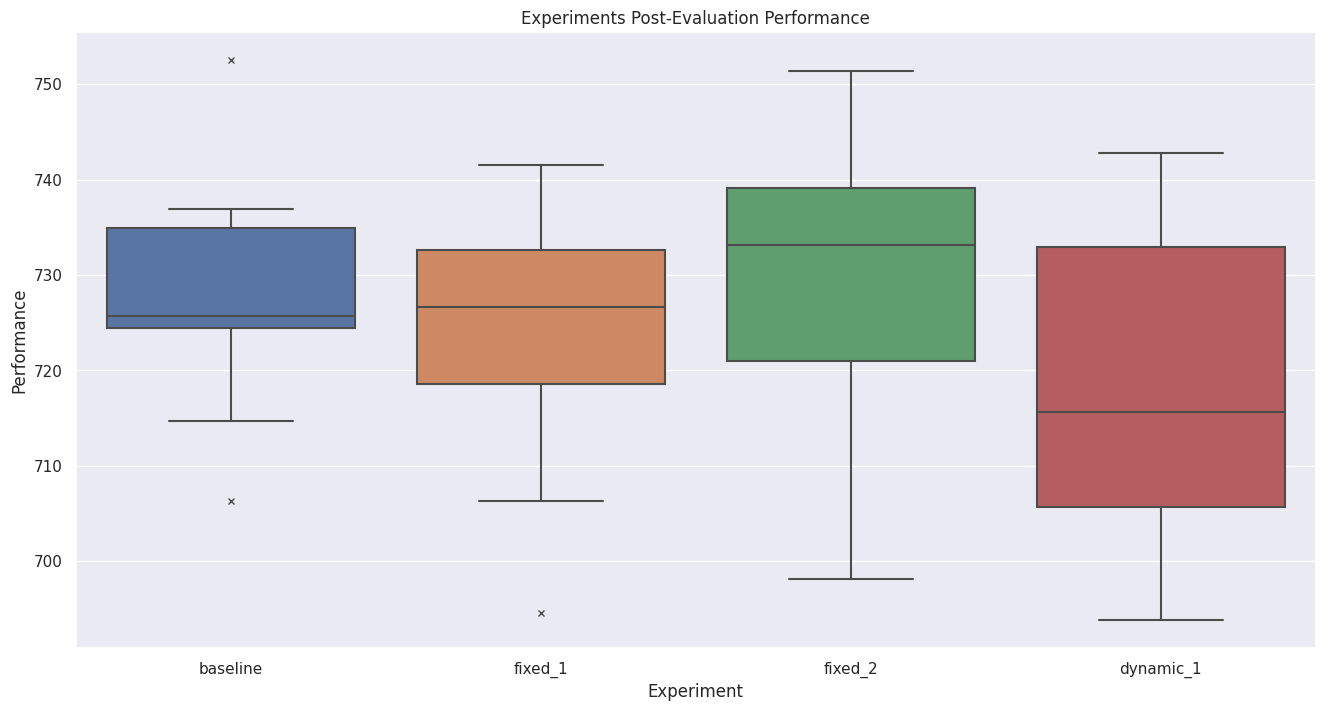

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(16,8)})


df = pd.DataFrame(tests_score)
sns.boxplot(df, flierprops={"marker": "x"})
plt.title("Experiments Post-Evaluation Performance")
plt.ylabel("Performance")
plt.xlabel("Experiment")
plt.show()

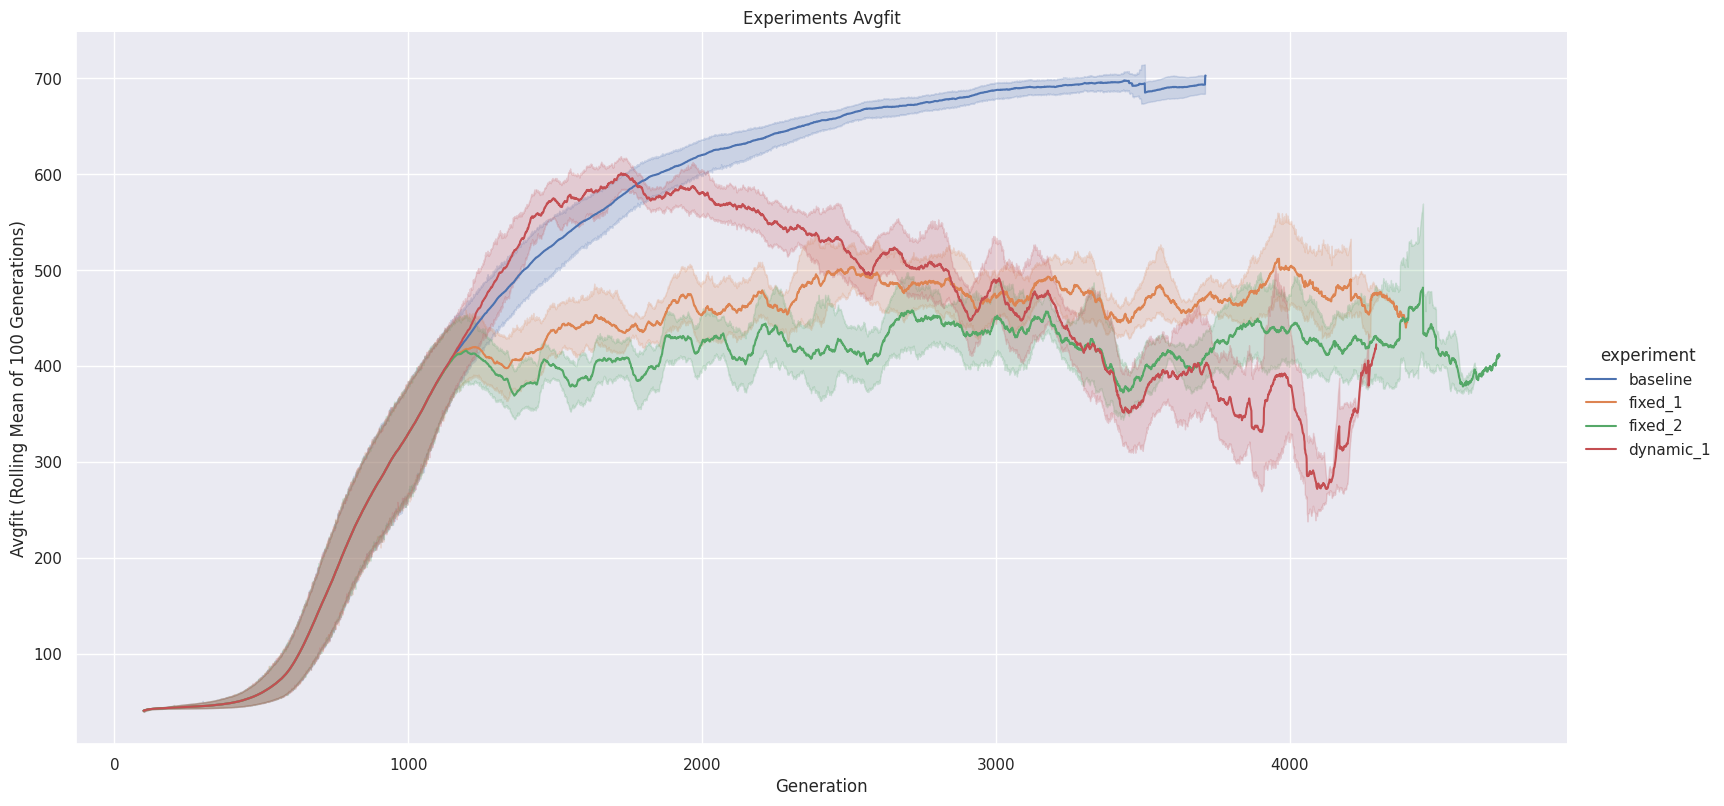

In [20]:
mean_stats = pd.DataFrame()

for experiment in experiments:
    experiment_df = pd.DataFrame(run_stats[experiment])
    experiment_df = experiment_df.T
    experiment_df.columns = seeds
    
    seeds_df = pd.DataFrame()
    for seed in seeds:
        rolling_mean = experiment_df[seed].rolling(100).mean()

        seed_df = pd.DataFrame({'gen': [i for i in range(len(experiment_df[seed]))], 'performance': rolling_mean})
        seed_df['seed'] = seed

        seeds_df = pd.concat([seeds_df, seed_df], ignore_index=True) if not seeds_df.empty else seed_df

    seeds_df['experiment'] = experiment
    mean_stats = pd.concat([mean_stats, seeds_df], ignore_index=True) if not mean_stats.empty else seeds_df

sns.relplot(mean_stats, x='gen', y='performance', hue='experiment', kind='line', estimator='mean', height=8, aspect=2)
plt.title("Experiments Avgfit")
plt.ylabel("Avgfit (Rolling Mean of 100 Generations)")
plt.xlabel("Generation")
plt.show()

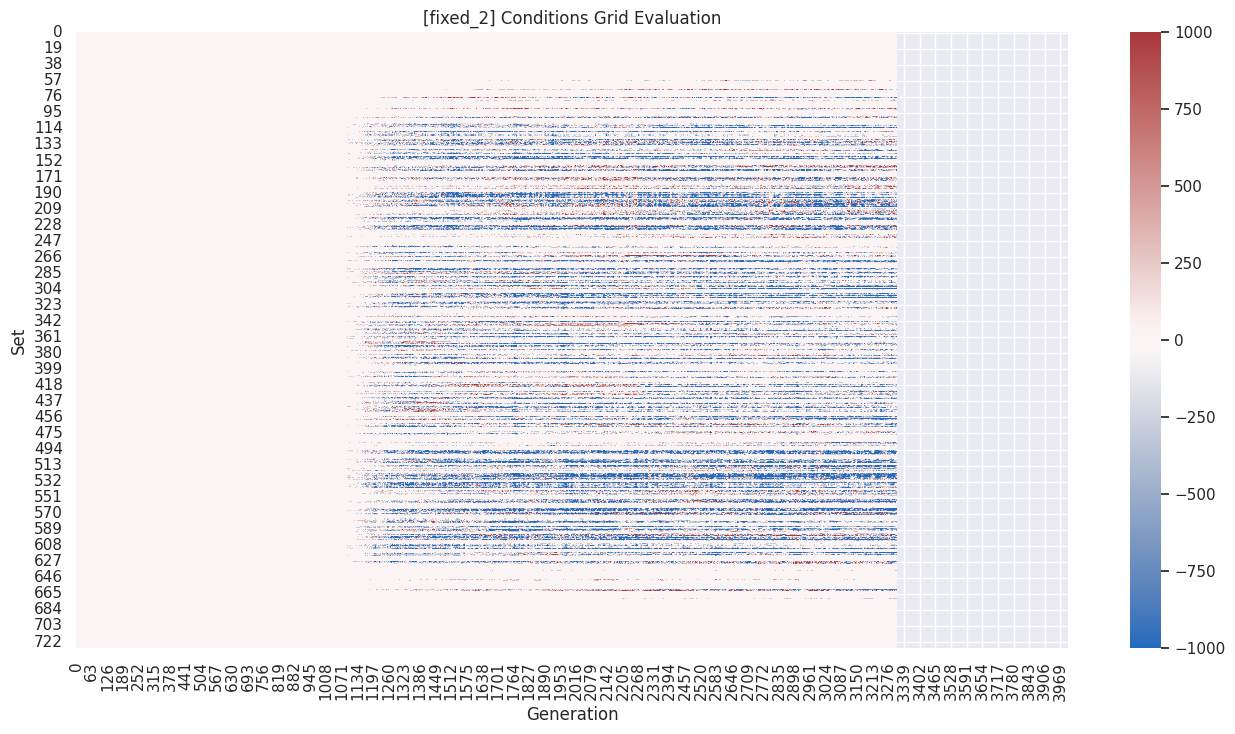

In [21]:
general = pd.DataFrame()
limit = 4000
experiment = "fixed_2"

for seed in seeds:
    baseline_data = f'../../datalake/data_baseline/data/xdpole/baseconditions'
    bdf = pd.read_csv(f'{baseline_data}/{seed}_run.csv')
    integrated_data = f'../../datalake/data_{experiment}/data/xdpole/baseconditions'
    idf = pd.read_csv(f'{integrated_data}/{seed}_run.csv')

    diff = idf[:limit] - bdf[:limit]
    general = diff if general.empty else general + diff

general = general / len(seed)

sns.heatmap(general.T, vmin=-1000, vmax=1000, cmap="vlag")
plt.title(f"[{experiment}] Conditions Grid Evaluation")
plt.ylabel("Set")
plt.xlabel("Generation")
plt.show()